# Polynomial Fitting

Similarly to the linear fit and the transit model we can instead fit our data with a polynomial model. The difference from the linear fit tutorial is that in this case we'll generate a slightly different polynomial function  for each wavelength and see how well our model can recover the parameters.

In [1]:
from chromatic_fitting import *
from pymc3 import Normal, Uniform

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.0.4!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.3.14
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


First we'll create a Rainbow object from chromatic and then add a wavelength-dependent polynomial model:

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

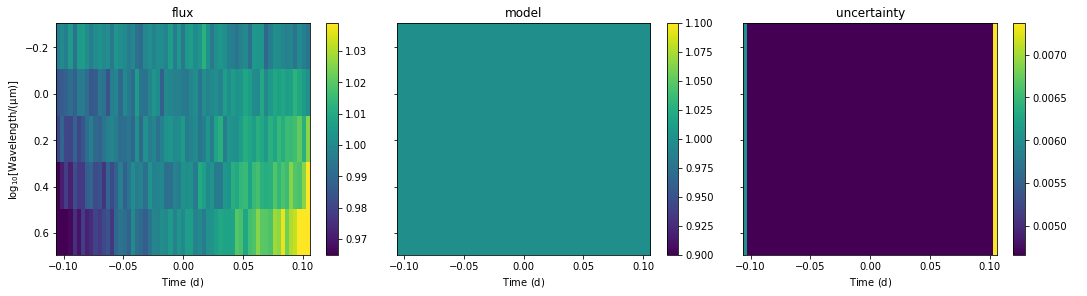

In [2]:
# create simulated rainbow
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=20)

# bin:
nw = 5
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# create wavelength-dep linear + constant model:
a = 0.0
b = 0.05
c = 0.0
d = 5.0
x = rb.time.to_value("day")

true_a, true_b, true_c, true_d, poly = [],[],[],[],[]

for i in range(rb.nwave):
    true_a.append(a + 1)
    true_b.append(b*i)
    true_c.append(c*i)
    true_d.append(d*i)
    poly.append((d*i*(x**3)) + (c*i*(x**2)) + (b*i*x))
rb.fluxlike['flux'] = rb.flux + np.array(poly)

# plot our Rainbow to see how it looks
rb.imshow_quantities();

Let's plot our data in 2-D so we can see the polynomial shapes we've added:

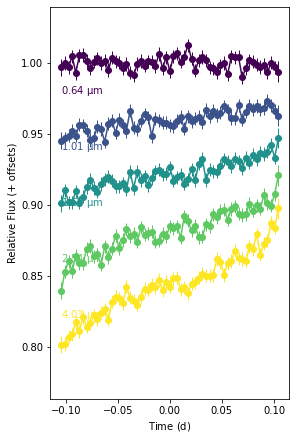

In [3]:
rb.plot_lightcurves();

## Create Polynomial Model

We set up the `PolynomialModel` similarly to the [linear model tutorial](https://catrionamurray.github.io/chromatic_fitting/tutorial_for_linear_fitting/), however, we need to provide the `degree` of the polynomial. By setting this argument we can fix some of our degrees to zero. For example if we have a linear model but we want a zero constant offset we could ignore the `p_0` parameter which would be fixed by default to 0. 

In [4]:
# set up polynomial model:
p = PolynomialModel(degree=3)

p.setup_parameters(
    p_0 = WavelikeFitted(Uniform,testval=0.01,upper=2,lower=-2),
    p_1 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=-1),
    p_2 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=-1),
    p_3 = WavelikeFitted(Uniform,testval=0.01,upper=25,lower=-5)
)

# print a summary of all params:
p.summarize_parameters()

polynomial_p_0 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>

polynomial_p_1 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>

polynomial_p_2 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>

polynomial_p_3 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>



In [5]:
# setup model the same way as for the transit model!:
p.attach_data(rb)
p.setup_lightcurves(store_models=True)
p.setup_likelihood()

Let's check our PyMC3 model and make sure that the parameters have been set up okay!

In [6]:
print(p._pymc3_model)

polynomial_p_0_interval__ ~ TransformedDistribution
polynomial_p_1_interval__ ~ TransformedDistribution
polynomial_p_2_interval__ ~ TransformedDistribution
polynomial_p_3_interval__ ~ TransformedDistribution
           polynomial_p_0 ~ Uniform
           polynomial_p_1 ~ Uniform
           polynomial_p_2 ~ Uniform
           polynomial_p_3 ~ Uniform
         polynomial_model ~ Deterministic
                     data ~ Normal


Looks good, now onto sampling our model...

## Sampling our Model

Now we can try to fit our model! Here we will first perform an optimization step (to give our sampling a good first guess) and then the actual NUTS sampling with a number of tuning and draw steps and chains that we define. We can also choose how many cores to assign to this sampling! Bear in mind that we have a decent number of parameters to fit (simultaneously) and so we want to make sure we have enough steps in the MCMC!

In [7]:
# optimize for initial values!
opt = p.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(start=opt, tune=2000, draws=4000, chains=4, cores=4)

optimizing logp for variables: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


message: Optimization terminated successfully.
logp: -6759054.489775105 -> 1198.0407161025278
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 24 seconds.


Now we can look at our results:

In [8]:
p.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

                             mean        sd   hdi_16%   hdi_84%  mcse_mean  \
polynomial_p_0[0, 0]     1.000401  0.000911  0.999461  1.001271   0.000006   
polynomial_p_0[1, 0]     0.998706  0.000894  0.997804  0.999589   0.000006   
polynomial_p_0[2, 0]     0.999819  0.000894  0.998937  1.000707   0.000005   
polynomial_p_0[3, 0]     1.000326  0.000906  0.999389  1.001205   0.000006   
polynomial_p_0[4, 0]     1.000868  0.000907  0.999988  1.001795   0.000005   
...                           ...       ...       ...       ...        ...   
polynomial_model[4, 56]  1.034254  0.001445  1.032903  1.035787   0.000010   
polynomial_model[4, 57]  1.036787  0.001601  1.035279  1.038472   0.000012   
polynomial_model[4, 58]  1.039461  0.001783  1.037657  1.041235   0.000014   
polynomial_model[4, 59]  1.042280  0.001992  1.040251  1.044253   0.000016   
polynomial_model[4, 60]  1.045249  0.002227  1.043124  1.047589   0.000018   

                          mcse_sd      ess_bulk      ess_tail  

r_hat parameters are close to 1, which is a good sign that our chains have converged!

In [9]:
p.get_results(uncertainty=['hdi_16%','hdi_84%'])

,polynomial_p_0,polynomial_p_0_hdi_16%,polynomial_p_0_hdi_84%,polynomial_p_1,polynomial_p_1_hdi_16%,polynomial_p_1_hdi_84%,polynomial_p_2,polynomial_p_2_hdi_16%,polynomial_p_2_hdi_84%,polynomial_p_3,polynomial_p_3_hdi_16%,polynomial_p_3_hdi_84%,wavelength
w0,1.000401,0.999461,1.001271,0.000036,-0.015728,0.021566,-0.223875,-0.406165,-0.035955,-1.356224,-4.999997,-0.393627,0.639572482934883 micron
w1,0.998706,0.997804,0.999589,0.083203,0.061699,0.108945,-0.007965,-0.184337,0.183664,2.083404,-1.723883,4.963689,1.013209338074884 micron
w2,0.999819,0.998937,1.000707,0.082669,0.059184,0.108806,0.096982,-0.077061,0.283585,9.597367,6.166383,13.126755,1.604998553797903 micron
w3,1.000326,0.999389,1.001205,0.140467,0.116314,0.165541,-0.199776,-0.385401,-0.013314,12.948787,9.532613,16.42188,2.542436455025025 micron
w4,1.000868,0.999988,1.001795,0.195104,0.171312,0.212971,0.102704,-0.083607,0.285445,20.298474,18.488193,24.16846,4.027407446906737 micron


In [10]:
model = p.get_model()
model.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4'])

## Plot Results

Remember that handy `plot_lightcurves()` function from earlier? Once we have generated a model it *should* now overplot those models on top of the data.

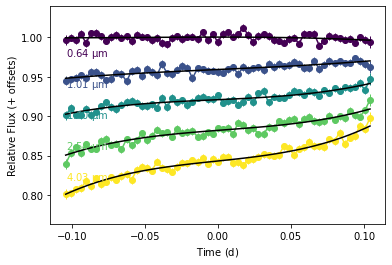

In [11]:
p.plot_lightcurves()

We can also use the `chromatic` functions wrapped in `chromatic_fitting` that can let us look at the residuals:

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


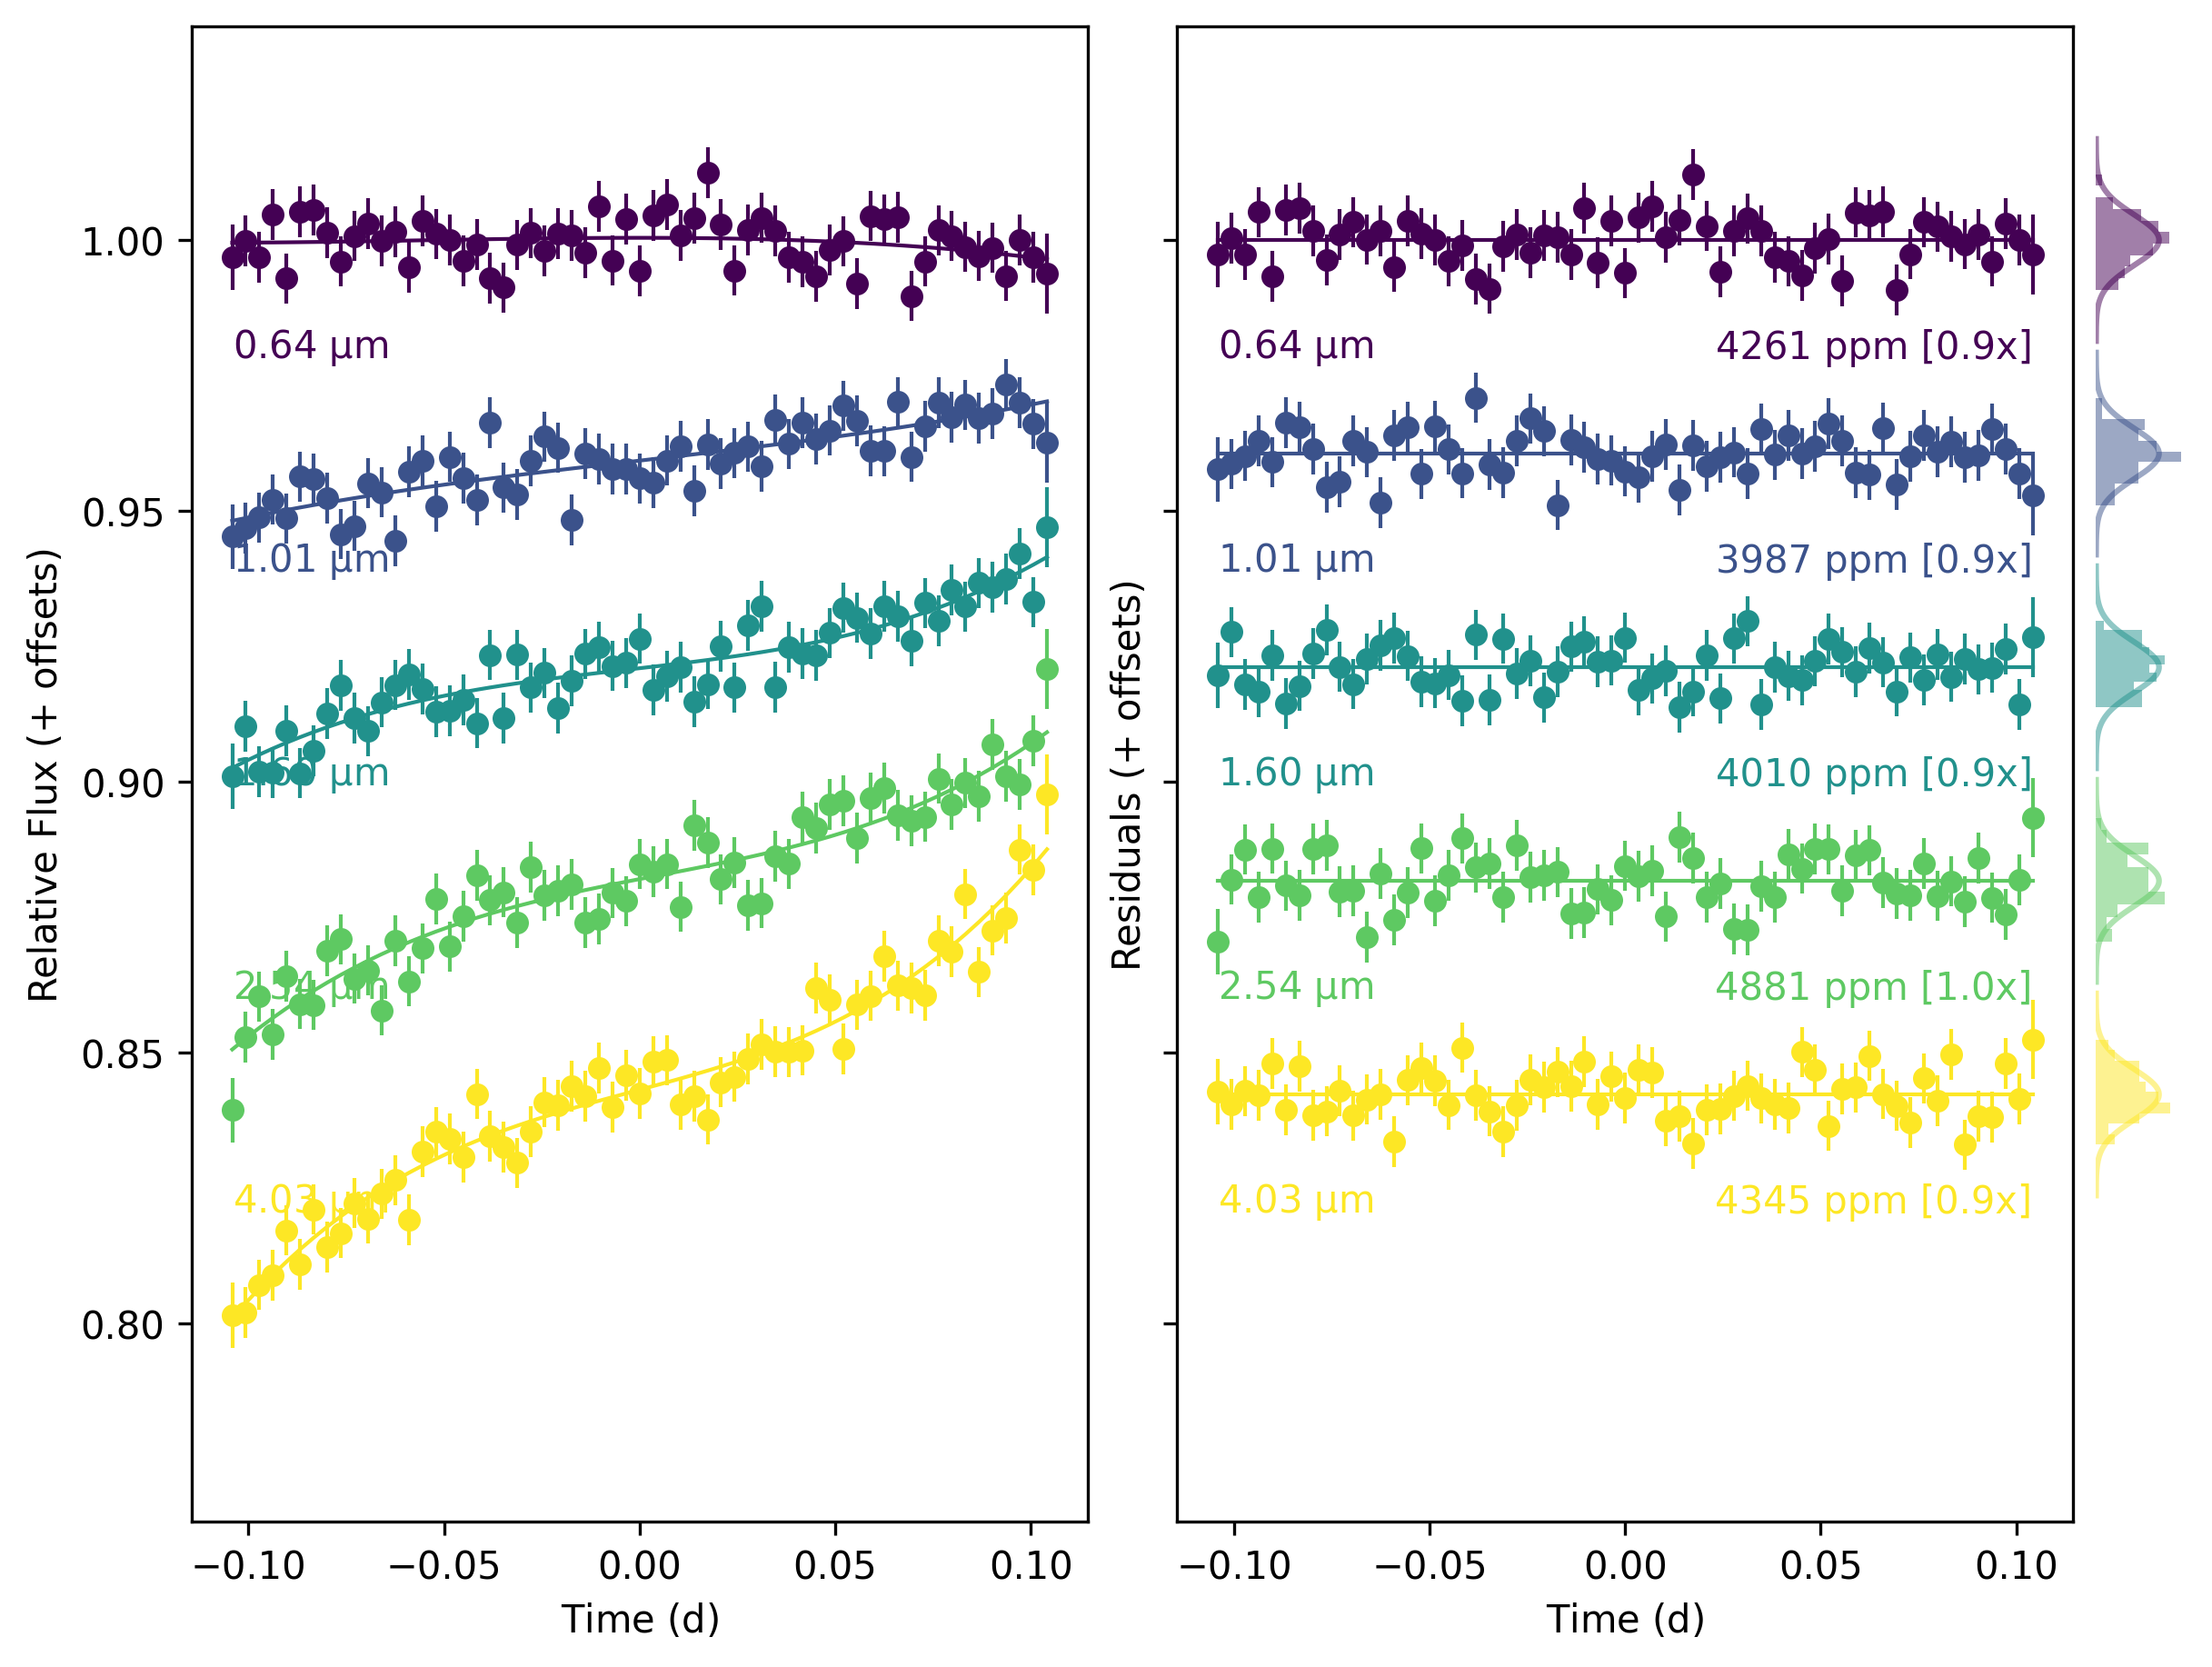

In [12]:
p.plot_with_model_and_residuals()

🌈🤖 'planet_model' doesn't exist and will be skipped.



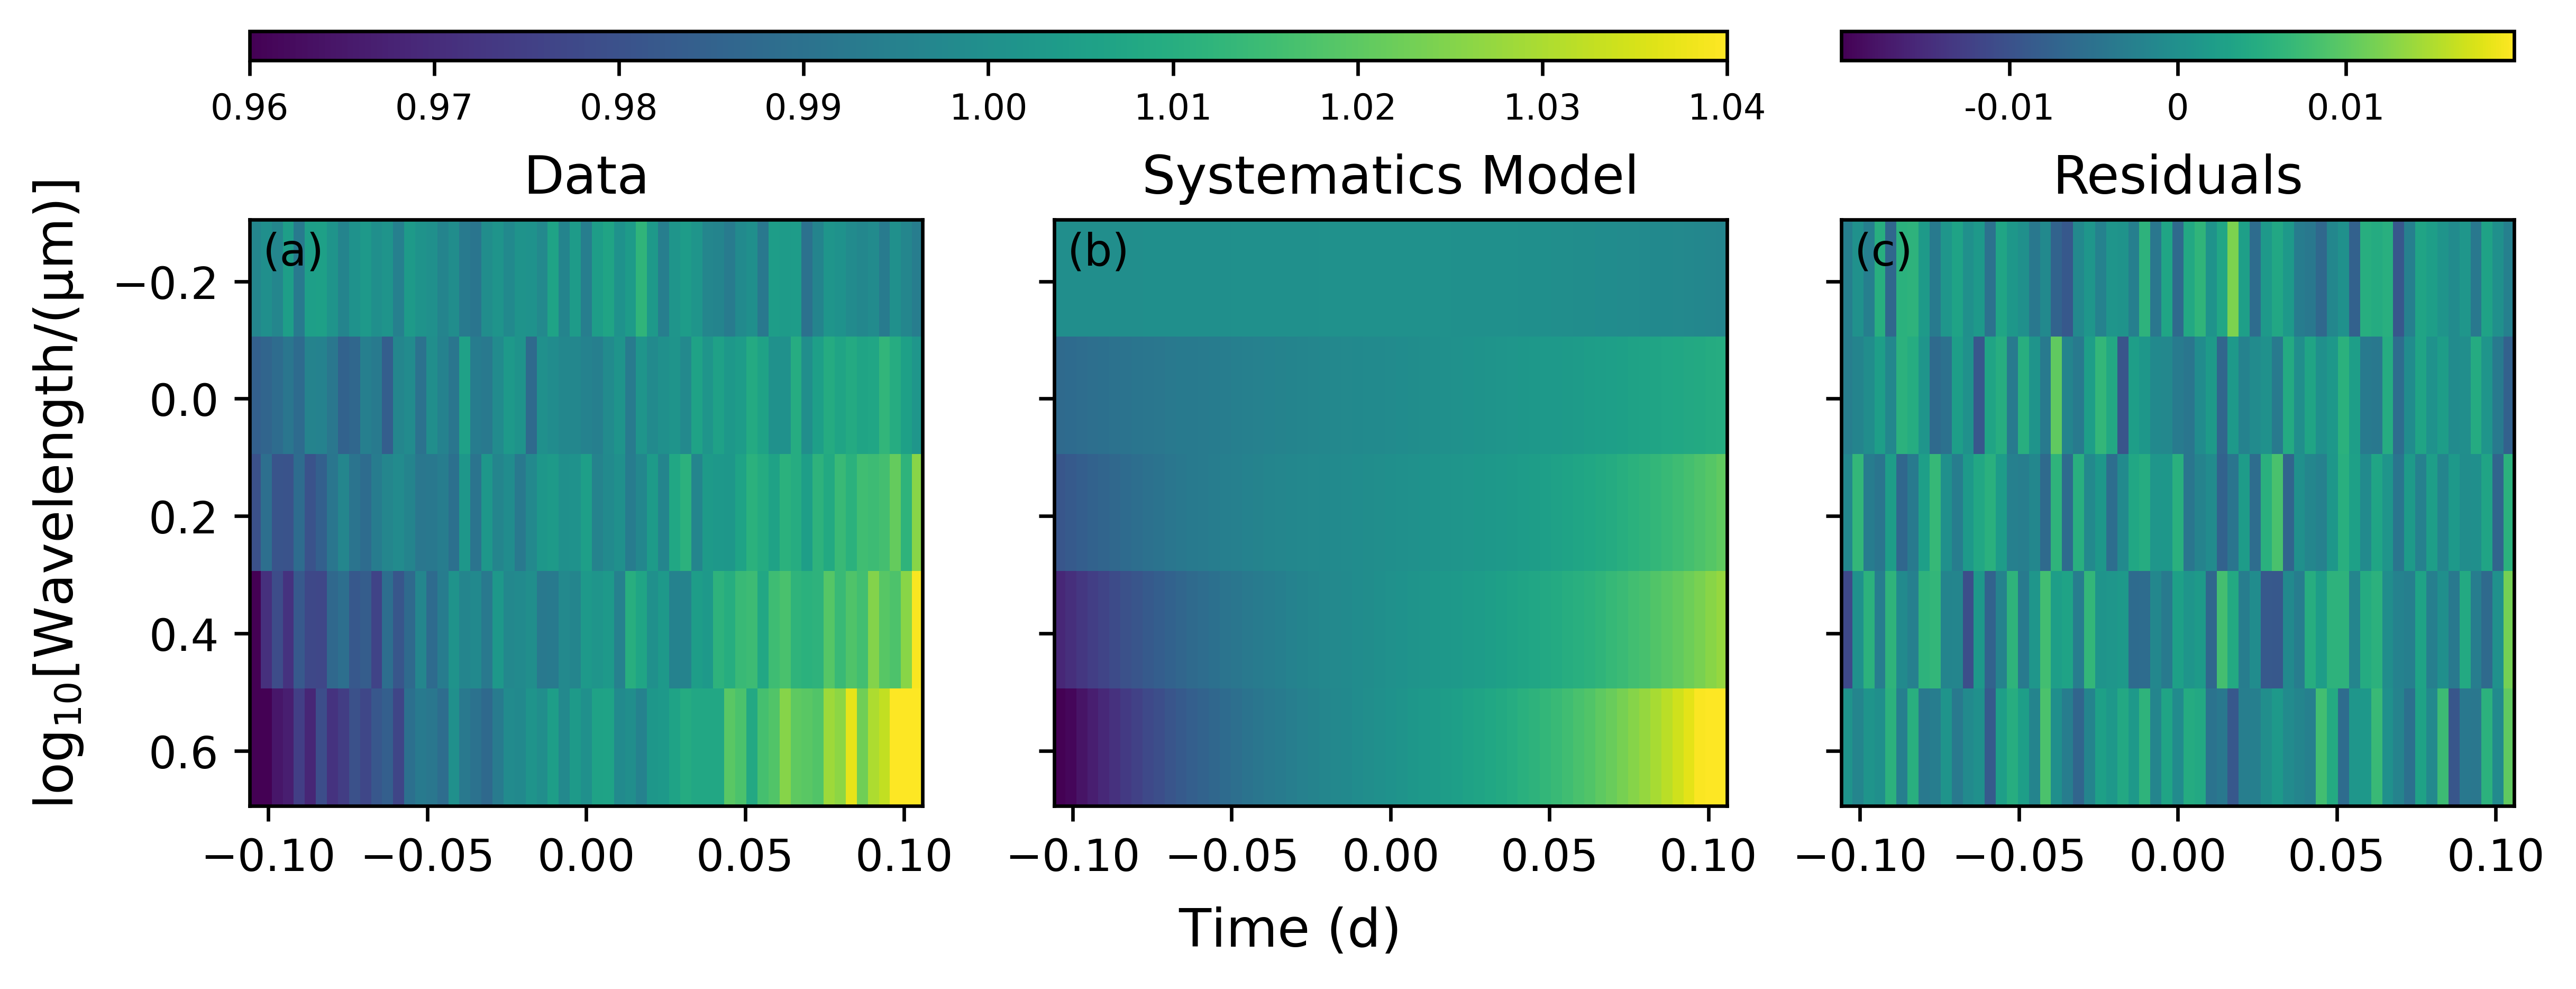

In [13]:
p.imshow_with_models(vlimits_data=[0.96, 1.04])

## Compare Results to the True Values

We can also compare our fitted results to the true values we put in:

In [14]:
results = p.get_results(uncertainty=['sd','sd'])
results

,polynomial_p_0,polynomial_p_0_sd,polynomial_p_1,polynomial_p_1_sd,polynomial_p_2,polynomial_p_2_sd,polynomial_p_3,polynomial_p_3_sd,wavelength
w0,1.000401,0.000911,0.000036,0.019019,-0.223875,0.187025,-1.356224,2.47295,0.639572482934883 micron
w1,0.998706,0.000894,0.083203,0.023481,-0.007965,0.184434,2.083404,3.280187,1.013209338074884 micron
w2,0.999819,0.000894,0.082669,0.025206,0.096982,0.183283,9.597367,3.529401,1.604998553797903 micron
w3,1.000326,0.000906,0.140467,0.024749,-0.199776,0.187554,12.948787,3.479409,2.542436455025025 micron
w4,1.000868,0.000907,0.195104,0.020971,0.102704,0.18487,20.298474,2.832365,4.027407446906737 micron


In [15]:
print("\t\t\tTrue, \tFitted")
for w in range(p.data.nwave):
    for i, coeff in zip(range(p.degree+1),[true_a, true_b, true_c, true_d]):
        print(f"wavelength {w}, p_{i}:\t {round(coeff[w],2)}, \t",results.loc[f'w{w}'][f"{p.name}_p_{i}"],"+/-",results.loc[f'w{w}'][f"{p.name}_p_{i}_sd"])

			True, 	Fitted
wavelength 0, p_0:	 1.0, 	 1.0004009 +/- 0.0009112
wavelength 0, p_1:	 0.0, 	 3.59e-05 +/- 0.0190194
wavelength 0, p_2:	 0.0, 	 -0.2238754 +/- 0.1870253
wavelength 0, p_3:	 0.0, 	 -1.3562242 +/- 2.4729501
wavelength 1, p_0:	 1.0, 	 0.9987062 +/- 0.0008937
wavelength 1, p_1:	 0.05, 	 0.0832034 +/- 0.0234813
wavelength 1, p_2:	 0.0, 	 -0.007965 +/- 0.1844339
wavelength 1, p_3:	 5.0, 	 2.0834044 +/- 3.2801874
wavelength 2, p_0:	 1.0, 	 0.9998189 +/- 0.0008936
wavelength 2, p_1:	 0.1, 	 0.0826689 +/- 0.025206
wavelength 2, p_2:	 0.0, 	 0.0969819 +/- 0.1832829
wavelength 2, p_3:	 10.0, 	 9.5973666 +/- 3.5294007
wavelength 3, p_0:	 1.0, 	 1.0003262 +/- 0.0009064
wavelength 3, p_1:	 0.15, 	 0.140467 +/- 0.0247491
wavelength 3, p_2:	 0.0, 	 -0.1997763 +/- 0.1875543
wavelength 3, p_3:	 15.0, 	 12.9487871 +/- 3.4794093
wavelength 4, p_0:	 1.0, 	 1.0008682 +/- 0.0009066
wavelength 4, p_1:	 0.2, 	 0.1951036 +/- 0.0209713
wavelength 4, p_2:	 0.0, 	 0.1027041 +/- 0.18487
wavelength 

Let's plot the data, the true regression line and our fit and see how they compare (If we used `store_model=True` at the `.setup_lightcurves()` stage then we could easily generate a 1-sigma region for the model using the errors stored in the summary table!):

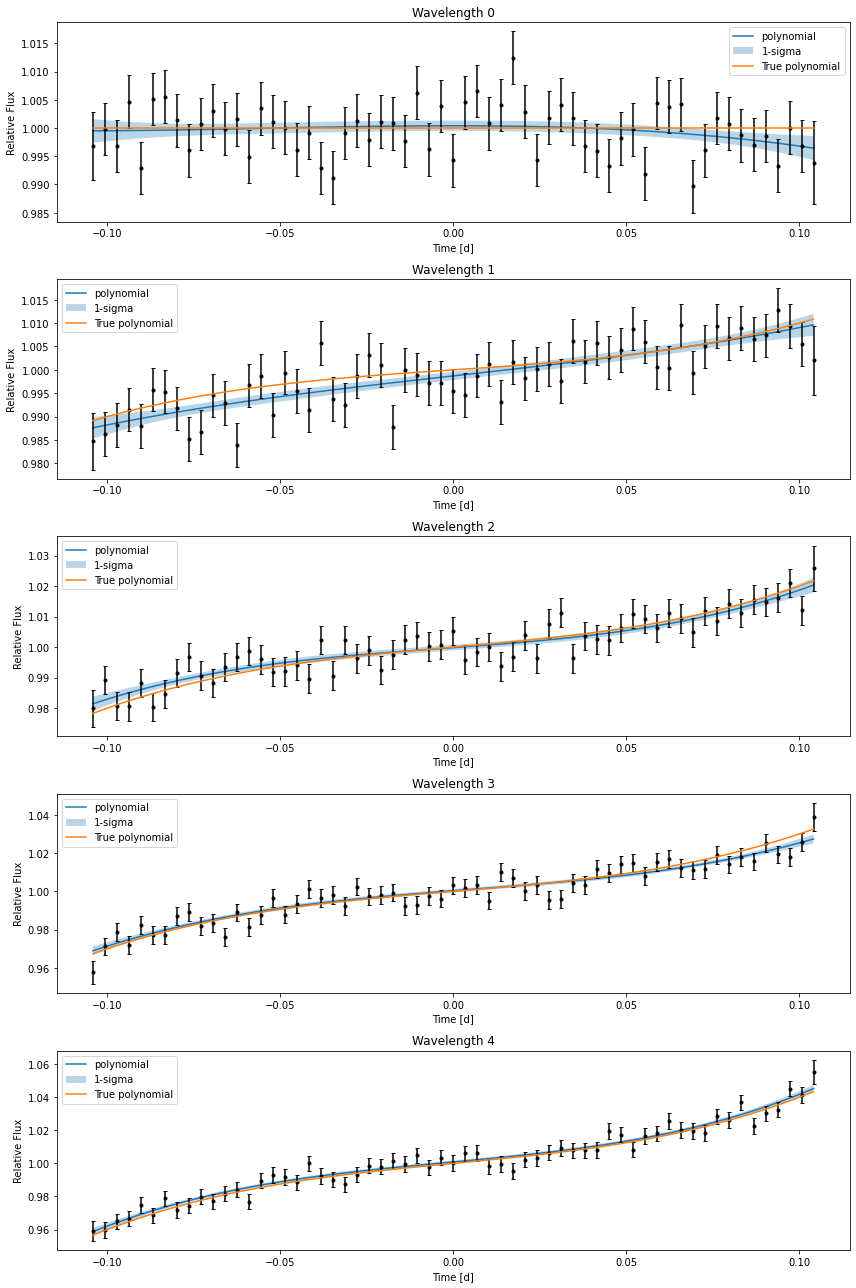

In [16]:
fig, ax = plt.subplots(p.data.nwave, figsize=(12,18))
p.plot_model(ax=ax)
plt.tight_layout();

# get 1-sigma region (only if store_models=True!!):
onesigma={}
for w in range(p.data.nwave):
    if f"w{w}" not in onesigma.keys():
        onesigma[f"w{w}"] = []
    for t in range(p.data.ntime):
        onesigma[f"w{w}"].append(p.summary["sd"][f"{p.name}_model[{w}, {t}]"])
        
        
for i in range(len(poly)):
    ax[i].fill_between(p.data.time.to_value("d"), np.array(model[f"w{i}"])-onesigma[f"w{i}"], np.array(model[f"w{i}"])+onesigma[f"w{i}"], label='1-sigma', alpha=0.3)
    ax[i].plot(p.data.time, poly[i] + 1, label="True polynomial")
    ax[i].legend()

This is a good example to see where the model does a good job of fitting, and where, when the noise is larger than the signal, it can overfit (wavelength 0).